# Imports

In [1]:
import xarray as xr
from xarray.groupers import UniqueGrouper
import numpy as np
import xeofs as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
ds = xr.open_dataset('/glade/work/acruz/CESM21SSTs.nc')

In [3]:
ds

<xarray.Dataset> Size: 28GB
Dimensions:  (lat: 192, lon: 288, time: 1260, member: 100)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 10kB 1910-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: member
Data variables:
    SST      (member, time, lat, lon) float32 28GB ...

# Data select

In [4]:
%%time
# time = 101 years * 12 months = 1,212
# ds = ds.sel(time=slice('1914-01-01', '2014-12-01'))
ds = ds.sel(time=slice('1920-01-01', '2014-12-01'))
# Easier and faster to shift lons to -180, 180
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)

# roll data and then assign coords, to avoid using where
ATL_ds = ds.sel(lat=slice(-10, 10), lon=slice(-60, 20))


ATL_ds = ATL_ds.assign_coords({'member': ATL_ds['member']})
ATL_ds

CPU times: user 4.33 ms, sys: 43 μs, total: 4.37 ms
Wall time: 4.38 ms


<xarray.Dataset> Size: 652MB
Dimensions:  (lat: 22, time: 1140, member: 100, lon: 65)
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * time     (time) object 9kB 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
  * lon      (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    SST      (member, time, lat, lon) float32 652MB ...

# Anomalies

In [5]:
clim = ATL_ds.groupby('time.month').mean(dim='time')

In [6]:
anom = ATL_ds.groupby('time.month') - clim

In [7]:
anom

<xarray.Dataset> Size: 652MB
Dimensions:  (lat: 22, time: 1140, lon: 65, member: 100)
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * time     (time) object 9kB 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
  * lon      (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    month    (time) int64 9kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    SST      (member, time, lat, lon) float32 652MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

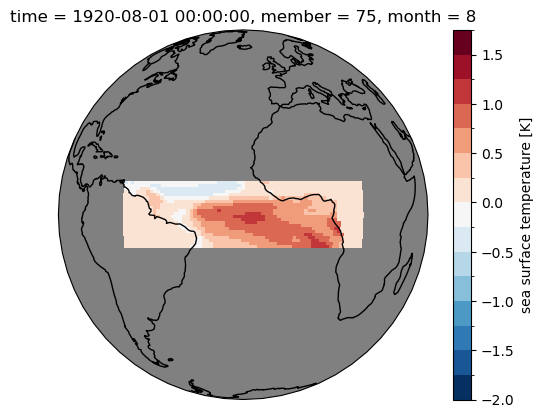

In [8]:
# quick test plot
p = anom['SST'].isel(member=75, time=7).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-20, 0), facecolor="gray"),
    transform=ccrs.PlateCarree(), levels=np.arange(-2, 2, 0.25)
)
p.axes.set_global()

p.axes.coastlines()

# Detrend
Remove later if we decide on it

In [9]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


anom_dtrend = detrend_dim(anom['SST'], dim='time')
anom

<xarray.Dataset> Size: 652MB
Dimensions:  (lat: 22, time: 1140, lon: 65, member: 100)
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * time     (time) object 9kB 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
  * lon      (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    month    (time) int64 9kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    SST      (member, time, lat, lon) float32 652MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

# EOF

In [91]:
%%time
'''
Members are not kept separate from decomposoition and its loosing the dimension after the fit

model.scores() not returning list of DataArray in same way as model.components
from source code the type annotation is dataarray instead of DataObject

as alternative I will simply loop through members and call a  new fit everytime
'''
anom_members = [anom_dtrend.sel(member=m) for m in anom_dtrend['member']]

EOF_members = []
for m in anom_members:
    model = xe.single.EOF(n_modes=3, use_coslat=True)
    model.fit(m, dim='time')
    components = model.components()
    PCs = model.scores(normalized=False)
    xplained_var = model.explained_variance_ratio()
    member_result = xr.Dataset({'components' : components, 'PCs' : PCs, 'ex_var' : xplained_var})
    EOF_members.append(member_result)

EOF_members = xr.concat(EOF_members, dim='member')
EOF_members

CPU times: user 8.17 s, sys: 201 μs, total: 8.17 s
Wall time: 8.59 s


<xarray.Dataset> Size: 6MB
Dimensions:     (member: 100, mode: 3, lat: 22, lon: 65, time: 1140)
Coordinates:
  * lat         (lat) float64 176B -9.895 -8.953 -8.01 ... 8.01 8.953 9.895
  * lon         (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
  * member      (member) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * mode        (mode) int64 24B 1 2 3
  * time        (time) object 9kB 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
    month       (time) int64 9kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    components  (member, mode, lat, lon) float64 3MB -1.354e-21 ... -0.0
    PCs         (member, mode, time) float64 3MB 10.84 1.321 ... -3.127 -5.913
    ex_var      (member, mode) float64 2kB 0.6177 0.1356 ... 0.1509 0.06291

# Scaling and normalizing

In [51]:
pc_std = EOF_members['PCs'].std(dim='time')
pc_mean = EOF_members['PCs'].mean(dim='time')

In [52]:
normalized_PCs = (EOF_members['PCs'] - pc_mean) / pc_std
scaled_EOF = EOF_members['components'] * pc_std

In [54]:
normalized_PCs

<xarray.DataArray 'PCs' (member: 100, mode: 3, time: 1140)> Size: 3MB
array([[[ 1.05366908,  0.12838044, -0.17080917, ...,  1.27033865,
          1.48220337,  1.1167795 ],
        [ 0.21324601, -0.50713074, -0.75926991, ...,  0.62710857,
          0.57882898,  0.88583218],
        [-1.16702095, -2.32828767, -2.20193114, ..., -0.31856957,
         -0.18668738,  0.29362302]],

       [[-0.41770051, -0.55292368, -0.3925    , ...,  2.46000511,
          2.14526218,  2.27500223],
        [-0.43274539, -0.16316618,  0.18848324, ...,  0.39344484,
          0.02045487,  0.80907348],
        [ 0.18193488,  0.14384052,  0.32526536, ...,  0.11237769,
          0.88320634,  0.54167655]],

       [[ 1.09000195,  0.68102423,  0.41800767, ...,  1.79683698,
          2.30933211,  2.24224386],
        [-0.82254471, -2.03573944, -2.13186141, ...,  0.70580111,
          0.20219142,  0.36003045],
        [-0.60934592, -2.59317128, -2.28233889, ...,  0.62902269,
          0.22615374,  0.34685552]],
...
       [[ 1.21368715,  0.92732949,  1.22502775, ...,  0.55091627,
          0.56661333,  0.34030602],
        [-0.66053505, -1.45343903, -2.8387904 , ...,  0.66923598,
          0.32389468,  1.09636083],
        [ 0.88531143, -0.06558417,  0.6341438 , ..., -1.144303  ,
         -1.12893284, -0.38633917]],

       [[ 1.52830839,  0.86369905,  1.1911522 , ...,  0.31865542,
          0.04438975, -0.18050034],
        [-1.59154836, -1.55708506, -1.07699718, ..., -0.19881392,
          0.391133  ,  0.65199662],
        [-0.65317895, -0.80104025, -0.67747532, ...,  2.09914744,
          1.92692707,  1.95804286]],

       [[-0.87182186, -1.03679557, -0.89994141, ...,  1.21274923,
          1.98935941,  2.28821363],
        [ 0.35296583,  0.2847394 ,  0.3339512 , ...,  1.00037704,
          0.65441886,  0.12814507],
        [-0.96150481, -1.00468741, -1.15792038, ..., -0.64182324,
         -1.06733611, -2.0181008 ]]])
Coordinates:
  * mode     (mode) int64 24B 1 2 3
  * time     (time) object 9kB 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    month    (time) int64 9kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-07-03 15:33:36
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

# CANI and EANI

In [55]:
PC1 = normalized_PCs.sel(mode=1)
PC3 = normalized_PCs.sel(mode=3)

EOF1 = scaled_EOF.sel(mode=1)
EOF3 = scaled_EOF.sel(mode=3)

EAN = (EOF1 + EOF3) / (2 ** 0.5)
CAN = (EOF1 - EOF3) / (2 ** 0.5)

EANI = (PC1 + PC3) / (2 ** 0.5)
CANI = (PC1 - PC3) / (2 ** 0.5)

# using 5 months as in literature
roll = 5
EANI_roll = EANI.rolling(time=roll, center=True).mean()
CANI_roll = CANI.rolling(time=roll, center=True).mean()

# Variances

In [56]:
# select only the summer of the index
EANI_JJA = EANI_roll.where(EANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)
CANI_JJA = CANI_roll.where(CANI_roll.time.dt.month.isin([6, 7, 8]), drop=True)

EANI_JJA_mean = EANI_JJA.groupby('time.year').mean()
CANI_JJA_mean = CANI_JJA.groupby('time.year').mean()

var_roll = 21
EANI_var = EANI_JJA_mean.rolling(year=var_roll, center=True).var()
CANI_var = CANI_JJA_mean.rolling(year=var_roll, center=True).var()

CvE_r = CANI_var / EANI_var

# Plotting

## View data

In [68]:
EAN

<xarray.DataArray (member: 100, lat: 22, lon: 65)> Size: 1MB
array([[[-9.74904787e-16,  4.99110407e-17,  1.26571666e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.98635724e-01,  1.90964379e-01,  1.87996173e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.97378739e-01,  1.91971434e-01,  1.82115762e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.92549889e-01,  1.85656281e-01,  1.75984121e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-4.62833425e-16,  4.76345505e-16, -1.10024272e-17, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
        [ 1.63085348e-01,  1.57555772e-01,  1.55200659e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.58825095e-01,  1.57591769e-01,  1.53705223e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.56759351e-01,  1.56335803e-01,  1.52834828e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.21098788e-15, -4.47640433e-19, -2.67793742e-18, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.98533431e-01,  1.90163660e-01,  1.91267030e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.96488236e-01,  1.92489588e-01,  1.84045678e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.91146375e-01,  1.83280324e-01,  1.73561881e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * lat      (lat) float64 176B -9.895 -8.953 -8.01 -7.068 ... 8.01 8.953 9.895
  * lon      (lon) float64 520B -60.0 -58.75 -57.5 -56.25 ... 17.5 18.75 20.0
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-07-03 15:33:36
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

## Map function

In [63]:
def ds_map(ds_to_plt, bounds=[20, -60, 10, -10], name='figure'):
    fig, ax = plt.subplots(1, 1,
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.lon)

    ax.set_title(name)
    lat_ticks = np.arange(bounds[3], bounds[2], 5)
    lon_ticks = np.arange(bounds[1], bounds[0], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)


    def resize_colobar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])

    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.lat, cdat,
                              levels=np.arange(-0.4, 0.5, 0.05),
                              # levels=40,
                              transform=ccrs.PlateCarree(), cmap='inferno', extend='both')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    resize_colobar(None)
    # plt.savefig(name, dpi=300)
    plt.show()

## EOFs

### EOF ensemble means

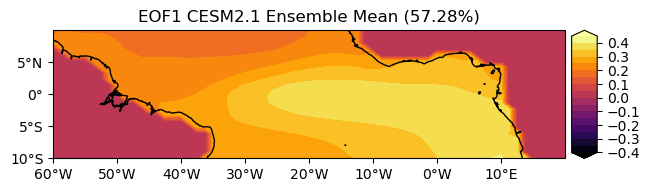

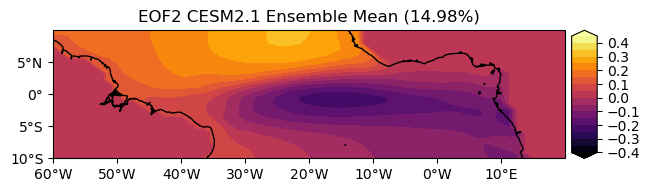

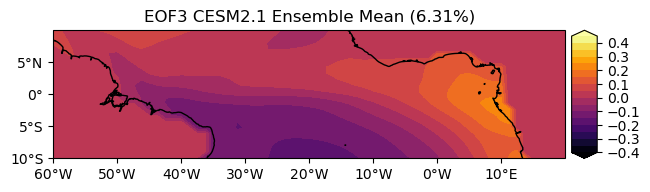

In [96]:
ens_mean_EOF1 = scaled_EOF.sel(mode=1).mean(dim='member')
ens_mean_xvar1 = EOF_members['ex_var'].sel(mode=1).mean(dim='member')
ens_mean_EOF2 = scaled_EOF.sel(mode=2).mean(dim='member')
ens_mean_xvar2 = EOF_members['ex_var'].sel(mode=2).mean(dim='member')
ens_mean_EOF3 = scaled_EOF.sel(mode=3).mean(dim='member')
ens_mean_xvar3 = EOF_members['ex_var'].sel(mode=3).mean(dim='member')


ds_map(ens_mean_EOF1, name=f'EOF1 CESM2.1 Ensemble Mean ({ens_mean_xvar1 * 100:.2f}%)')
ds_map(ens_mean_EOF2, name=f'EOF2 CESM2.1 Ensemble Mean ({ens_mean_xvar2 * 100:.2f}%)')
ds_map(ens_mean_EOF3, name=f'EOF3 CESM2.1 Ensemble Mean ({ens_mean_xvar3 * 100:.2f}%)')

### CAN and EAN ensemble mean

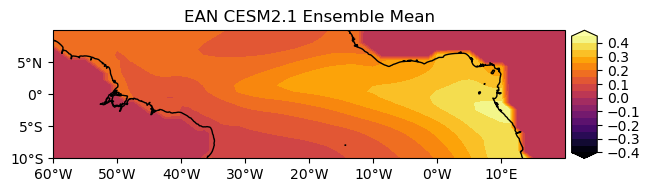

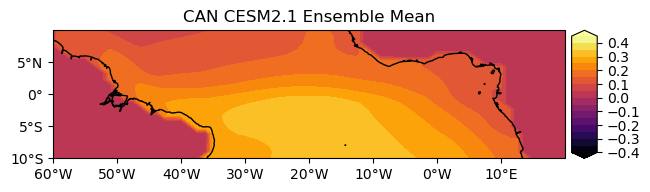

In [69]:
ens_mean_EAN = EAN.mean(dim='member')
ens_mean_CAN = CAN.mean(dim='member')

ds_map(ens_mean_EAN, name='EAN CESM2.1 Ensemble Mean')
ds_map(ens_mean_CAN, name='CAN CESM2.1 Ensemble Mean')

## Variance

### ensemble mean of eastern with ensemble mean of central through time

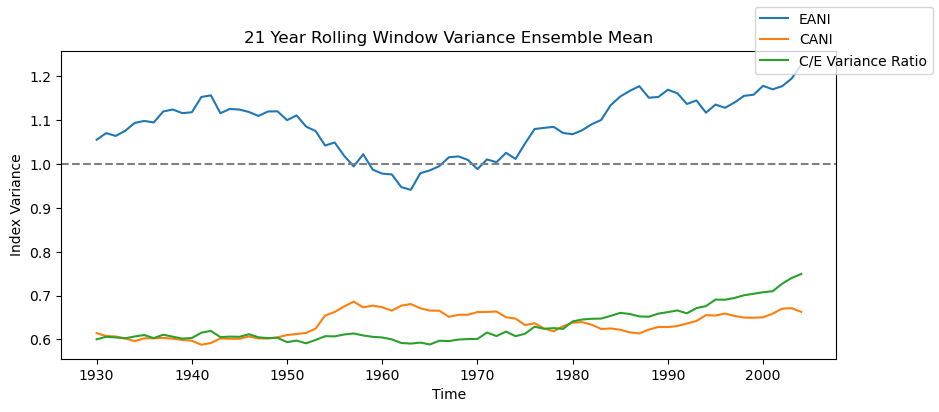

In [74]:
ens_CvE = CvE_r.mean(dim='member')
ens_EANIvar = EANI_var.mean(dim='member')
ens_CANIvar = CANI_var.mean(dim='member')

fig , ax1 = plt.subplots(figsize=(10, 4))

ens_mean.plot(ax=ax1, label='EANI')
ens_EANIvar.plot(ax=ax1, label='CANI')
ens_CANIvar.plot(ax=ax1, label='C/E Variance Ratio')
plt.title(f'21 Year Rolling Window Variance Ensemble Mean')
plt.ylabel('Index Variance')
plt.xlabel('Time')
ax1.axhline(1, color='grey', ls='--')
fig.legend()

### Eastern and central plot including all members and ensemble mean

### EANI

Text(0.5, 1.0, 'EANI 21 year rolling window variance')

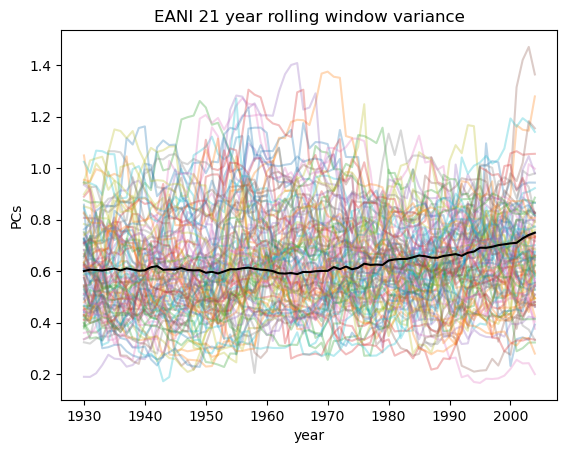

In [97]:
EANI_var.plot.line(hue='member', alpha=0.3, add_legend=False)
ens_CANIvar.plot.line(color='black')
plt.title("EANI 21 year rolling window variance")

### CANI

Text(0.5, 1.0, 'CANI 21 year rolling window variance')

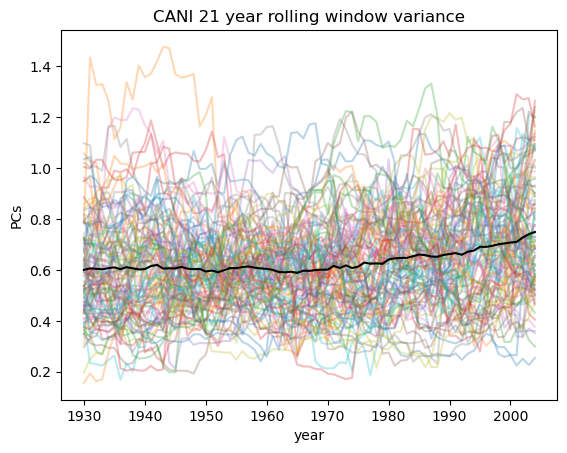

In [98]:
CANI_var.plot.line(hue='member', alpha=0.3, add_legend=False)
ens_CANIvar.plot.line(color='black')
plt.title('CANI 21 year rolling window variance')